En el ejemplo que vamos a utilizar, vamos a imaginarnos que una organización sin fines de lucro soporta su operación mediante la organización periódica de una campaña para recaudar fondos por correo. Esta organización ha creado una base de datos con más de 40 mil personas que por lo menos una vez en el pasado ha sido donante. La campaña de recaudación de fondos se realiza mediante el envío a una lista de correo (o un subconjunto de ella) de un regalo simbólico y la solicitud de una donación. Una vez que se planifica la campaña, el costo total de la misma se conoce de forma automática
La idea es que, utilizando las técnicas de Machine Learning sobre la base de datos de esta organización, podamos ayudarla a maximizar los beneficios de la campaña de recaudación, esto es, lograr el máximo importe posible de dinero recaudado, minimizando lo más que se pueda el costo total de la campaña
Nuestro objetivo es ayudar a esta organización sin fines de lucro a seleccionar de su lista de correo los donantes a los que debe abordar a los efectos de maximizar los beneficios de la campaña de recaudación

In [2]:
# Importando las librerías que vamos a utilizar
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder

# graficos incrustados
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})

In [5]:
# importando el dataset a un Dataframe de Pandas
ONG_data = pd.read_csv('ONG.csv', header=0)

In [ ]:
# Examinando las primeras filas y columnas del dataset
ONG_data.head()

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,MDMAUD,DOMAIN,CLUSTER,AGE,AGEFLAG,HOMEOWNR,CHILD03,CHILD07,CHILD12,CHILD18,NUMCHLD,INCOME,GENDER,WEALTH1,HIT,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,...,RAMNT_10,RAMNT_11,RAMNT_12,RAMNT_13,RAMNT_14,RAMNT_15,RAMNT_16,RAMNT_17,RAMNT_18,RAMNT_19,RAMNT_20,RAMNT_21,RAMNT_22,RAMNT_23,RAMNT_24,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MINRDATE,MAXRAMNT,MAXRDATE,LASTGIFT,LASTDATE,FISTDATE,NEXTDATE,TIMELAG,AVGGIFT,IDX,DONOR_FLAG,DONOR_AMOUNT,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
0,8901,GRI,0,IL,61081,,,3712,0,,,,,XXXX,T2,36.0,60.0,,,,,,,NaN,NaN,F,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,NaN,NaN,NaN,10.0,11.0,11.0,11.0,NaN,NaN,NaN,NaN,NaN,11.0,9.0,240.0,31,14,5.0,9208,12.0,9402,10.0,9512,8911,9003.0,4.0,7.741935,95515,0,0.0,0,L,4,E,X,X,X,39.0,C
1,9401,NWN,0,LA,70611,,,0,0,,,,,XXXX,T2,39.0,NaN,,U,,,,,NaN,2.0,F,9.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,11.0,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,31.0,5,4,5.0,9507,11.0,9508,11.0,9508,9401,9407.0,6.0,6.200000,109359,0,0.0,1,L,3,E,X,X,X,38.0,C
2,9401,MSD,1,TN,37127-,,,3211,0,,,,,XXXX,T1,35.0,65.0,I,,,,,,NaN,NaN,M,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,3,1,3.0,9309,15.0,9504,15.0,9504,9309,9404.0,7.0,9.333333,49909,0,0.0,0,L,1,F,X,X,X,34.0,B
3,8901,ENQ,0,MN,56475,,,2603,0,,,,,XXXX,R3,51.0,72.0,,H,,,,,2.0,4.0,F,2.0,16,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,5.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,48.0,9,5,4.0,9507,7.0,9102,6.0,9601,8905,8910.0,5.0,5.333333,85548,0,0.0,1,L,4,D,X,X,X,57.0,D
4,9201,HCC,1,LA,70791,,,0,0,X,,,,XXXX,T2,40.0,NaN,,,,,,,NaN,NaN,M,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,50.0,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,NaN,245.0,12,4,5.0,9211,50.0,9412,25.0,9612,9210,9211.0,1.0,20.416667,12890,0,0.0,0,L,1,G,X,X,X,38.0,B


In [ ]:
# Controlando la cantidad de registros
ONG_data['DONOR_AMOUNT'].count()

47720

In [ ]:
# Controlando valores nulos
ONG_data.isnull().any().any()

True

In [ ]:
# Agrupando columnas por tipo de datos
tipos = ONG_data.columns.to_series().groupby(ONG_data.dtypes).groups

# Armando lista de columnas categóricas
ctext = tipos[np.dtype('object')]
len(ctext)  # cantidad de columnas con datos categóricos. 

68

In [ ]:
# Armando lista de columnas numéricas
columnas = ONG_data.columns  # lista de todas las columnas
cnum = list(set(columnas) - set(ctext))
len(cnum)

413

Ahora ya logramos separar a las 481 columnas que tiene nuestro dataset. 68 columnas contienen datos categóricos y 413 contienen datos cuantitativos. Procedamos a inferir los valores faltantes.

In [ ]:
# Completando valores faltantas datos cuantititavos
for c in cnum:
    mean = ONG_data[c].mean()
    ONG_data[c] = ONG_data[c].fillna(mean)

In [ ]:
# Completando valores faltantas datos categóricos
for c in ctext:
    mode = ONG_data[c].mode()[0]
    ONG_data[c] = ONG_data[c].fillna(mode)

In [ ]:
# Controlando que no hayan valores faltantes
ONG_data.isnull().any().any()

False

In [ ]:

# Calculando el porcentaje de donantes sobre toda la base de datos
porcent_donantes = (ONG_data[ONG_data.DONOR_AMOUNT 
                             > 0]['DONOR_AMOUNT'].count() * 1.0
       / ONG_data['DONOR_AMOUNT'].count()) * 100.0
print("El procentaje de donantes de la base de datos es {0:.2f}%"
      .format(porcent_donantes))

El procentaje de donantes de la base de datos es 5.08%


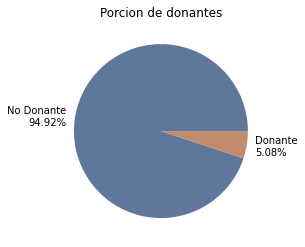

In [ ]:
# Grafico de totas del porcentaje de donantes
# Agrupando por DONOR_FLAG
donantes = ONG_data.groupby('DONOR_FLAG').IDX.count() 
# Creando las leyendas del grafico.
labels = [ 'Donante\n' + str(round(x * 1.0 / donantes.sum() * 
                            100.0, 2)) + '%'  for x in donantes ]
labels[0] = 'No ' + labels[0]

plt.pie(donantes, labels=labels)
plt.title('Porcion de donantes')
plt.show()

Aquí podemos ver que el porcentaje de personas que fueron donantes en el pasado es realmente muy bajo, solo un 5 % del total de la base de datos (2423 personas). Este es un dato importante a tener en cuenta ya que al existir tanta diferencia entre las clases a clasificar, esto puede afectar considerablemente a nuestro algoritmo de aprendizaje. Exploremos también un poco más en detalle a este grupo pequeño de personas que fueron donantes; veamos por ejemplo como se dividen de acuerdo a la cantidad de dinero donado.

In [ ]:

# Creando subset con solo los donates
ONG_donantes = ONG_data[ONG_data.DONOR_AMOUNT > 0]

# cantidad de donantes
len(ONG_donantes)

2423

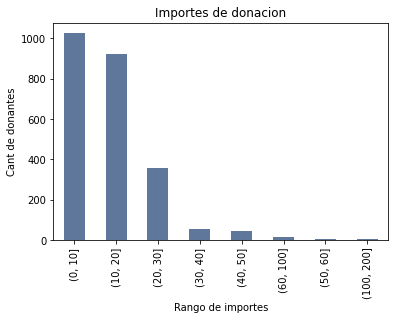

In [ ]:

# Analizando el importe de donanciones
# Creando un segmentos de importes
imp_segm = pd.cut(ONG_donantes['DONOR_AMOUNT'], 
                  [0, 10,  20, 30, 40, 50, 60, 100, 200])
# Creando el grafico de barras desde pandas
plot = pd.value_counts(imp_segm).plot(kind='bar',
                                      title='Importes de donacion')
plot.set_ylabel('Cant de donantes')
plot.set_xlabel('Rango de importes')
plt.show()

In [ ]:
# Agrupación por segmento segun importe donado.
pd.value_counts(imp_segm)

(0, 10]       1026
(10, 20]       921
(20, 30]       358
(30, 40]        53
(40, 50]        43
(60, 100]       15
(50, 60]         4
(100, 200]       3
Name: DONOR_AMOUNT, dtype: int64

In [ ]:
# importe de donación promedio
ONG_donantes['DONOR_AMOUNT'].mean()

15.598237721832438

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


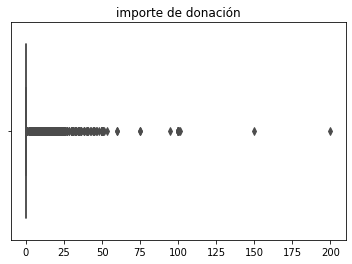

In [ ]:

# Gráfico de cajas del importe de donación
sns.boxplot(list(ONG_data['DONOR_AMOUNT']))
plt.title('importe de donación')
plt.show()

Este análisis nos muestra que la mayor cantidad de donaciones caen en un rango de importes entre 0 y 30, siendo la donación promedio 15.60. También podemos ver que donaciones que superen un importe de 50 son casos realmente poco frecuentes, por lo que constituyen valores atípicos y sería prudente eliminar estos casos al entrenar nuestro modelo para que no distorsionen los resultados.

Otra exploración interesante que podríamos realizar sobre nuestro dataset relacionado con los donantes, es ver como se divide este grupo en términos de género y edad. Comencemos con el género

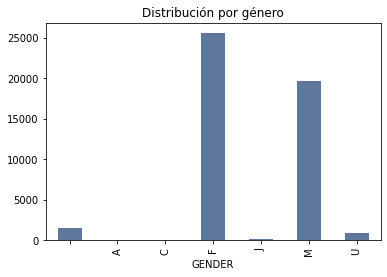

In [ ]:
# Grafico del género de los donantes
ONG_data.groupby('GENDER').size().plot(kind='bar')
plt.title('Distribución por género')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


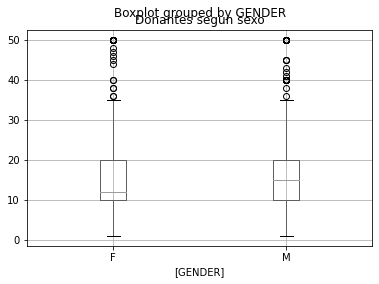

In [ ]:

# Donaciones segun el género
ONG_donantes[(ONG_donantes.DONOR_AMOUNT <= 50)
             & (ONG_donantes.GENDER.isin(['F', 'M'])
               )][['DONOR_AMOUNT', 'GENDER']].boxplot(by='GENDER')
plt.title('Donantes segun sexo')
plt.show()

In [ ]:
# Media de impote donado por mujeres
ONG_donantes[ONG_donantes.GENDER == 'F'][['DONOR_AMOUNT']].mean()

DONOR_AMOUNT    14.610311
dtype: float64

In [ ]:
# Media de impote donado por hombres
ONG_donantes[ONG_donantes.GENDER == 'M'][['DONOR_AMOUNT']].mean()

DONOR_AMOUNT    16.81989
dtype: float64

Aquí vemos que las mujeres suelen estar más propensas a donar, aunque donan un importe promedio menor (14.61) al que donan los hombres (16.82). Veamos ahora como se comportan las donaciones respecto a la edad.

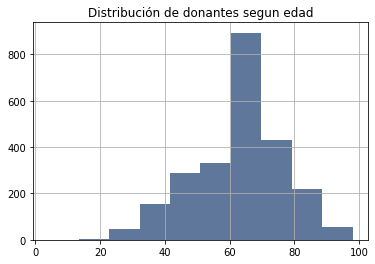

In [ ]:
# Distribución de la edad de los donantes
ONG_donantes['AGE'].hist().set_title('Distribución de donantes segun edad')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


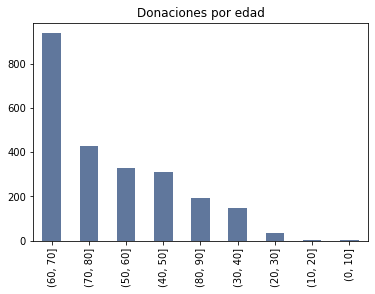

In [ ]:
# Agrupando la edad por rango de a 10
AGE2 = pd.cut(ONG_donantes['AGE'], range(0, 100, 10))
ONG_donantes['AGE2'] = AGE2

# Gráfico de barras de donaciones por edad
pd.value_counts(AGE2).plot(kind='bar', title='Donaciones por edad')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


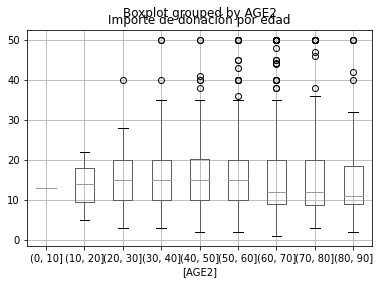

In [ ]:

# Importes de donación por grango de edad
ONG_donantes[ONG_donantes.DONOR_AMOUNT <= 50][['DONOR_AMOUNT', 
                                               'AGE2']].boxplot(by='AGE2')
plt.title('Importe de donación por edad')
plt.show()

En este último análisis podemos ver que la mayor cantidad de los donantes son personas de entre 60 y 70 años, aunque la media de importe donado más alta la tienen las personas que van desde los 30 a los 60 años.